# xBA 

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
batted_balls_2019 = pd.read_csv("baseball_savant_batted_ball_events.csv", 
                                header=None)
batted_balls_2019.columns = ['game_date','player_at_bat','batter_name',
                                         'statcast_distance',
                                         'launch_speed',
                                         'launch_angle','outcome']

In [3]:
batted_balls_2019['outcome'].value_counts()

field_out                    70253
single                       25390
double                        8330
home_run                      6617
force_out                     3491
grounded_into_double_play     3374
field_error                   1327
sac_fly                       1117
triple                         771
sac_bunt                       729
fielders_choice                396
double_play                    394
fielders_choice_out            282
sac_fly_double_play             11
sac_bunt_double_play             2
triple_play                      2
Name: outcome, dtype: int64

## Remove Bunts

In [4]:
batted_balls_2019 = (batted_balls_2019
                     [~batted_balls_2019['outcome'].str.contains('bunt')]
                     .reset_index(drop=True))

In [5]:
batted_balls_2019['outcome'].value_counts()

field_out                    70253
single                       25390
double                        8330
home_run                      6617
force_out                     3491
grounded_into_double_play     3374
field_error                   1327
sac_fly                       1117
triple                         771
fielders_choice                396
double_play                    394
fielders_choice_out            282
sac_fly_double_play             11
triple_play                      2
Name: outcome, dtype: int64

## Drop Nulls

In [6]:
batted_balls_2019 = (batted_balls_2019
                     .dropna(subset=['statcast_distance',
                                     'launch_speed',
                                     'launch_angle'])
                     .reset_index(drop=True))

## Encode is_hit_into_play_basehit

In [7]:
out_outcomes = ['field_out','force_out','grounded_into_double_play','field_error',
                'sac_fly','fielders_choice','fielders_choice_out','sac_fly_double_play',
                'triple_play']

In [8]:
batted_balls_2019['is_hit_into_play_basehit'] = ((~batted_balls_2019['outcome']
                                                 .isin(out_outcomes)).astype(int))

In [9]:
batted_balls_2019['is_hit_into_play_basehit'].mean()

0.3604906414357265

## Plot Heatmap

In [10]:
pd.to_datetime(batted_balls_2019['game_date']).dt.month.value_counts()

6    19103
8    18944
5    18530
9    18011
4    17744
7    16908
3     2369
Name: game_date, dtype: int64

Text(0.5, 43.0, 'Exit Velocity')

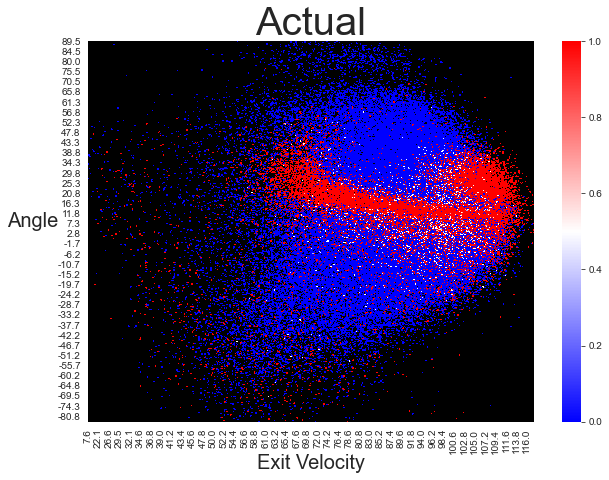

In [11]:
sns.set_style("dark", {"axes.facecolor": "#000000"})
actual_heatmap = batted_balls_2019.pivot_table(index="launch_angle", columns="launch_speed", values="is_hit_into_play_basehit")
actual_heatmap.sort_index(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=[10,7])
sns.heatmap(actual_heatmap, ax=ax, cmap='bwr', mask=actual_heatmap.isnull())
ax.set_title('Actual', size=40)
ax.set_ylabel('Angle', fontsize=20, rotation=0, labelpad=25)
ax.set_xlabel('Exit Velocity', fontsize=20, rotation=0, labelpad=0)

## Cross Validation

Using cross validation, fit series of models using varying values for k between 200 and 500. 

To evaluate performance we will use log loss (neg_log_loss).

Once GridSearchCV has tested all values of k, we will refit on all the data using the optimal value of k (refit=True)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [15]:
## BA
import numpy as np
np.random.seed(1)
params = {'weights': ['uniform'],
          'n_neighbors': range(250, 750, 25)}

knn_clf = GridSearchCV(KNeighborsClassifier(), params, n_jobs=5, 
                   cv=StratifiedKFold(n_splits=3, shuffle=True), 
                   scoring='neg_log_loss', refit=True)
knn_clf.fit(X=batted_balls_2019[['launch_angle','launch_speed']].values, 
            y=batted_balls_2019['is_hit_into_play_basehit'])

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=5,
             param_grid={'n_neighbors': range(250, 750, 25),
                         'weights': ['uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

## Plot CV Results

Plotting mean test log loss score across all CV 3 folds

In [16]:
knn_clf.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=400, p=2,
                     weights='uniform')

In [17]:
cv_result_test = {'k_neighbors': [x.get('n_neighbors') 
                                  for x in knn_clf.cv_results_['params']],
                 'mean_test_score': knn_clf.cv_results_.get('mean_test_score')}

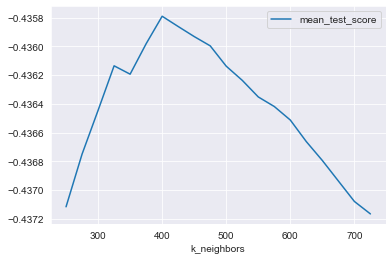

In [18]:
sns.set_style('darkgrid')
pd.DataFrame(cv_result_test).set_index('k_neighbors').plot()

## Plot Results

In [19]:
batted_balls_2019['knn_ba'] = (knn_clf
                               .predict_proba(X=batted_balls_2019[['launch_angle',
                                                                   'launch_speed']]
                                              .values)[:,1])

Text(0.5, 1.0, 'KNN - 400')

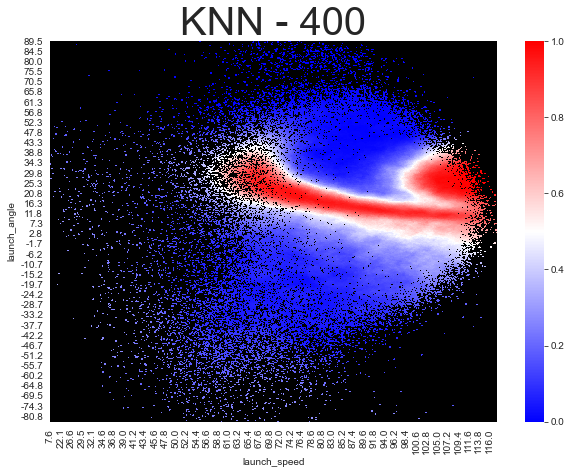

In [20]:
sns.set_style("dark", {"axes.facecolor": "#000000"})
knn_heatmap = batted_balls_2019.pivot_table(index="launch_angle", 
                                            columns="launch_speed", 
                                            values="knn_ba")
knn_heatmap.sort_index(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=[10,7])
sns.heatmap(knn_heatmap, ax=ax, cmap='bwr')
ax.set_title('KNN - 400', size=40)

## Compare to results at k=250 & k=750

In [21]:
knn_clf_250 = KNeighborsClassifier(n_neighbors=250)
knn_clf_250.fit(X=batted_balls_2019[['launch_angle','launch_speed']].values, 
            y=batted_balls_2019['is_hit_into_play_basehit'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=250, p=2,
                     weights='uniform')

Text(0.5, 1.0, 'KNN - 250')

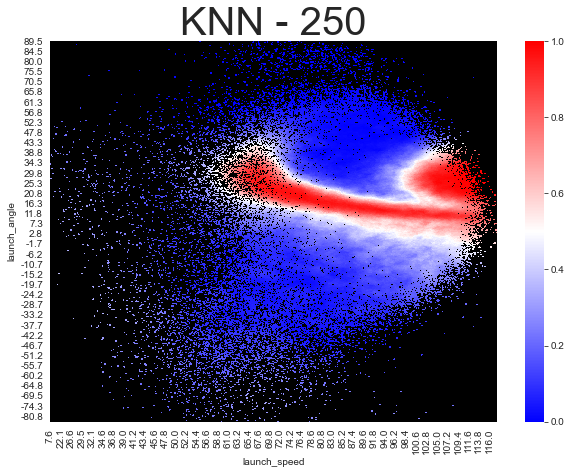

In [22]:
batted_balls_2019['knn250_ba'] = (knn_clf_250
                               .predict_proba(X=batted_balls_2019[['launch_angle',
                                                                   'launch_speed']]
                                              .values)[:,1])
sns.set_style("dark", {"axes.facecolor": "#000000"})
knn_heatmap = batted_balls_2019.pivot_table(index="launch_angle", 
                                            columns="launch_speed", 
                                            values="knn250_ba")
knn_heatmap.sort_index(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=[10,7])
sns.heatmap(knn_heatmap, ax=ax, cmap='bwr')
ax.set_title('KNN - 250', size=40)

In [23]:
knn_clf_750 = KNeighborsClassifier(n_neighbors=750)
knn_clf_750.fit(X=batted_balls_2019[['launch_angle','launch_speed']].values, 
            y=batted_balls_2019['is_hit_into_play_basehit'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=750, p=2,
                     weights='uniform')

Text(0.5, 1.0, 'KNN - 750')

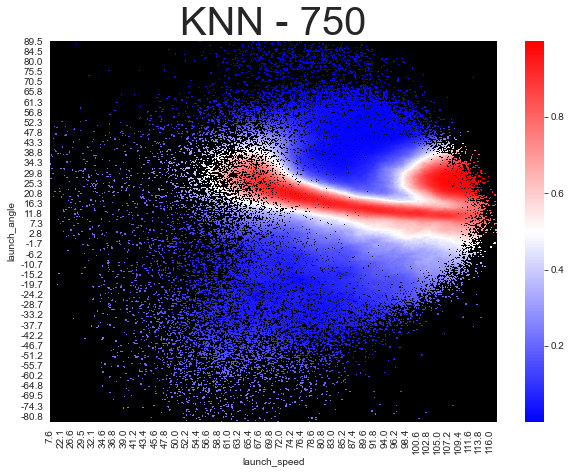

In [24]:
batted_balls_2019['knn750_ba'] = (knn_clf_750
                               .predict_proba(X=batted_balls_2019[['launch_angle',
                                                                   'launch_speed']]
                                              .values)[:,1])
sns.set_style("dark", {"axes.facecolor": "#000000"})
knn_heatmap = batted_balls_2019.pivot_table(index="launch_angle", 
                                            columns="launch_speed", 
                                            values="knn750_ba")
knn_heatmap.sort_index(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=[10,7])
sns.heatmap(knn_heatmap, ax=ax, cmap='bwr')
ax.set_title('KNN - 750', size=40)